In [1]:
import os
import sys
sys.path.append("/home/pervinco/BKAI-NeoPolyp")

import cv2
import yaml
import copy
import torch
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data.BKAIDataset import BKAIDataset
from utils import load_img_mask, decode_mask, decode_image, visualize
from data.batch_preprocess import encode_mask


In [2]:
with open("/home/pervinco/BKAI-NeoPolyp/config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min([os.cpu_count(), config["batch_size"] if config["batch_size"] > 1 else 0, 8])

In [3]:
data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
text_path = f"{data_dir}/train.txt"

with open(text_path, "r") as f:
    files = [x.strip() for x in f.readlines()]

print(len(files))

800


711 a0b47aa6b7b1fecb5579bf4a5ced589c


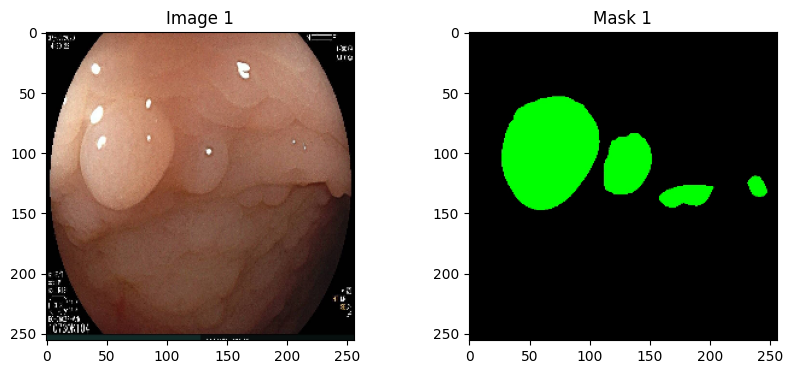

In [4]:
index = random.randint(0, len(files)-1)
index = 711
file = files[index]
print(index, file)

image_path, mask_path = f"{image_dir}/{file}.jpeg", f"{mask_dir}/{file}.jpeg"
image, mask = load_img_mask(image_path, mask_path)

visualize([image], [mask])

In [5]:
def paste_polyp(I, L, alpha=0.7, iterations=10):
    # Crop the polyp area from the image and label
    hs, ws = np.where(L == 1)
    he, we = hs.max(), ws.max()
    hs, ws = hs.min(), ws.min()
    
    If = I[hs:he, ws:we]
    Lf = L[hs:he, ws:we]
    
    # Initialize the potential map
    M = np.random.rand(*I.shape[:2])
    M[L == 1] = float('inf')
    
    height, width = he - hs, we - ws

    for _ in range(iterations):
        # Find the coordinate with the lowest potential
        px, py = np.unravel_index(M.argmin(), M.shape)
        
        # Define the candidate area
        candidate_area = (slice(px, px + height), slice(py, py + width))
        
        # Check if the candidate area is within image boundaries
        if candidate_area[0].stop > I.shape[0] or candidate_area[1].stop > I.shape[1]:
            M[px, py] = float('inf')
            continue
        
        # Check overlap
        if np.any(L[candidate_area] & Lf):
            M[candidate_area] = float('inf')
            continue
        
        # Paste the polyp onto the candidate area
        I[candidate_area] = alpha * I[candidate_area] + (1 - alpha) * If
        L[candidate_area] = alpha * L[candidate_area] + (1 - alpha) * Lf
        
        # Update the potential map for the pasted area
        M[candidate_area] = float('inf')
        
        # Spread potential to neighbors
        kernel = np.ones((3, 3), np.float32) / 9
        M = cv2.filter2D(M, -1, kernel)
    
    return I, L


329 7979870116d06046f5d8dd18841d318d


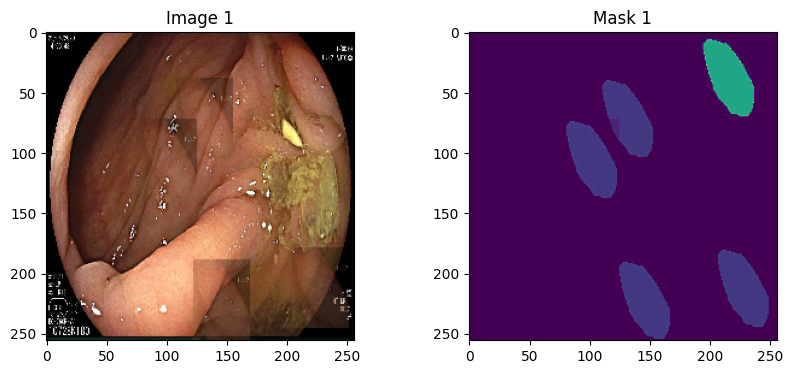

In [6]:
index = random.randint(0, len(files)-1)
# index = 711
file = files[index]
print(index, file)

image_path, mask_path = f"{image_dir}/{file}.jpeg", f"{mask_dir}/{file}.jpeg"
sample_image, sample_mask = load_img_mask(image_path, mask_path)
sample_mask = cv2.cvtColor(sample_mask, cv2.COLOR_BGR2GRAY)

result_image, result_mask = paste_polyp(sample_image, sample_mask)
visualize([result_image], [result_mask])


In [7]:
def paste_polyp(I, L_color, alpha=0.7, iterations=10):
    L_gray = cv2.cvtColor(L_color, cv2.COLOR_BGR2GRAY)
    # Crop the polyp area from the grayscale label image
    hs, ws = np.where(L_gray == 1)
    if not hs.any() or not ws.any():
        return L_color

    he, we = hs.max(), ws.max()
    hs, ws = hs.min(), ws.min()
    
    If = I[hs:he, ws:we]
    Lf_gray = L_gray[hs:he, ws:we]
    Lf_color = L_color[hs:he, ws:we]
    
    # Initialize the potential map
    M = np.random.rand(*I.shape[:2])
    M[L_gray == 1] = float('inf')
    
    height, width = he - hs, we - ws

    for _ in range(iterations):
        # Find the coordinate with the lowest potential
        px, py = np.unravel_index(M.argmin(), M.shape)
        
        # Define the candidate area
        candidate_area = (slice(px, px + height), slice(py, py + width))
        
        # Check if the candidate area is within image boundaries
        if candidate_area[0].stop > I.shape[0] or candidate_area[1].stop > I.shape[1]:
            M[px, py] = float('inf')
            continue
        
        # Check overlap using grayscale label
        if np.any(L_gray[candidate_area] & Lf_gray):
            M[candidate_area] = float('inf')
            continue
        
        # Paste the polyp onto the candidate area in the color label
        I[candidate_area] = alpha * I[candidate_area] + (1 - alpha) * If
        L_color[candidate_area] = alpha * L_color[candidate_area] + (1 - alpha) * Lf_color
        L_gray[candidate_area] = cv2.cvtColor(L_color[candidate_area], cv2.COLOR_BGR2GRAY)
        
        # Update the potential map for the pasted area
        M[candidate_area] = float('inf')
        
        # Spread potential to neighbors
        kernel = np.ones((3, 3), np.float32) / 9
        M = cv2.filter2D(M, -1, kernel)

    return I, L_color


678 7f9b9d49e2f4ee17979870116d06046f


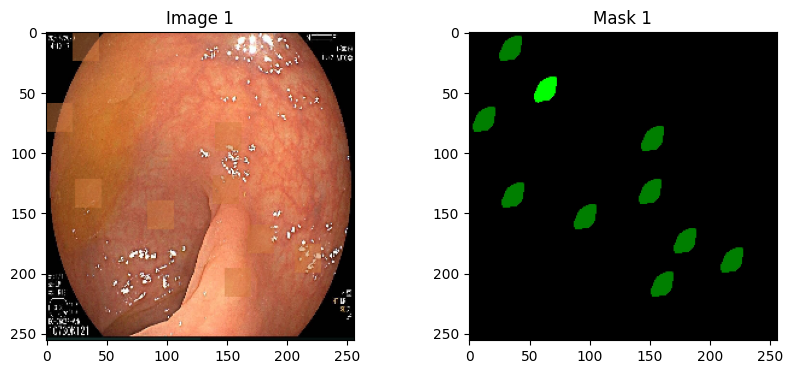

In [8]:
index = random.randint(0, len(files)-1)
# index = 711
file = files[index]
print(index, file)

image_path, mask_path = f"{image_dir}/{file}.jpeg", f"{mask_dir}/{file}.jpeg"
sample_image, sample_mask = load_img_mask(image_path, mask_path)
# sample_mask = cv2.cvtColor(sample_mask, cv2.COLOR_BGR2GRAY)

result_image, result_mask = paste_polyp(sample_image, sample_mask, alpha=0.5)
visualize([result_image], [result_mask])


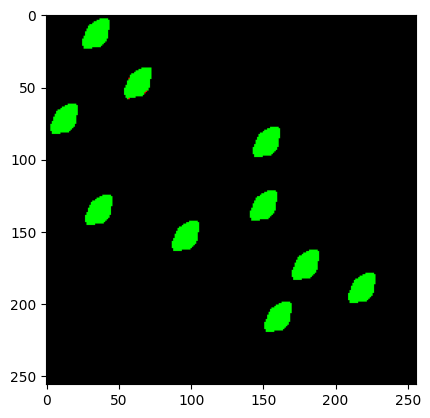

In [9]:
encoded_mask = encode_mask(result_mask)
decoded_mask = decode_mask(encoded_mask)
plt.imshow(decoded_mask)